### Résulats

#### Partie 5 - Analyse des résultats et vérification du model


In [1]:
%matplotlib inline

import random
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from IPython.display import display
from keras.models import load_model
from keras.metrics import MeanIoU

sys.path.append('..')
import Modules.utils as utils
import Modules.init as init
import Modules.display as disp
import Modules.generator as gen

datasets_dir = init.init('U-NET analysis')

<br>**Projet M1 - Détection d'anomalies sur imagerie médicale - U-NET analysis**

Version              : 2
Notebook id          : U-NET analysis
Run time             : Thursday 16 February 2023, 16:23:16
Hostname             : ludovic-ubu (Linux)
Tensorflow log level : Info + Warning + Error  (=0)
Datasets dir         : /media/ludovic/Cache/ENID
Run dir              : ./run
Update keras cache   : False
tensorflow           : 2.8.0
tensorflow.keras     : 2.8.0
numpy                : 1.21.5
skimage              : 0.19.2
matplotlib           : 3.5.1
pandas               : 1.3.5


In [2]:
seed=24
batch_size= 20

val_img_path = os.path.join(datasets_dir, 'DATASET', 'Validation', 'Images')
val_mask_path = os.path.join(datasets_dir, 'DATASET', 'Validation', 'Masks')
val_img_gen = gen.Generator(val_img_path, val_mask_path, batch_size, seed)

model = load_model("ENDOMETRIOSIS_UNET_SEG_JAC_FINAL.hdf5", compile=False)

test_image_batch, test_mask_batch = val_img_gen.__next__()

2023-02-16 16:23:22.915099: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 1244 images belonging to 1 classes.
Found 1244 images belonging to 1 classes.


Test pour une prédiction

(384, 640, 3)
(384, 640, 1)
(1, 384, 640, 3)
(1, 384, 640, 1)
(384, 640, 1)


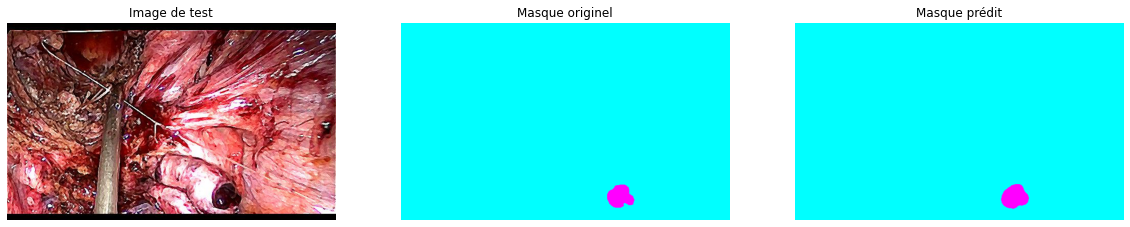

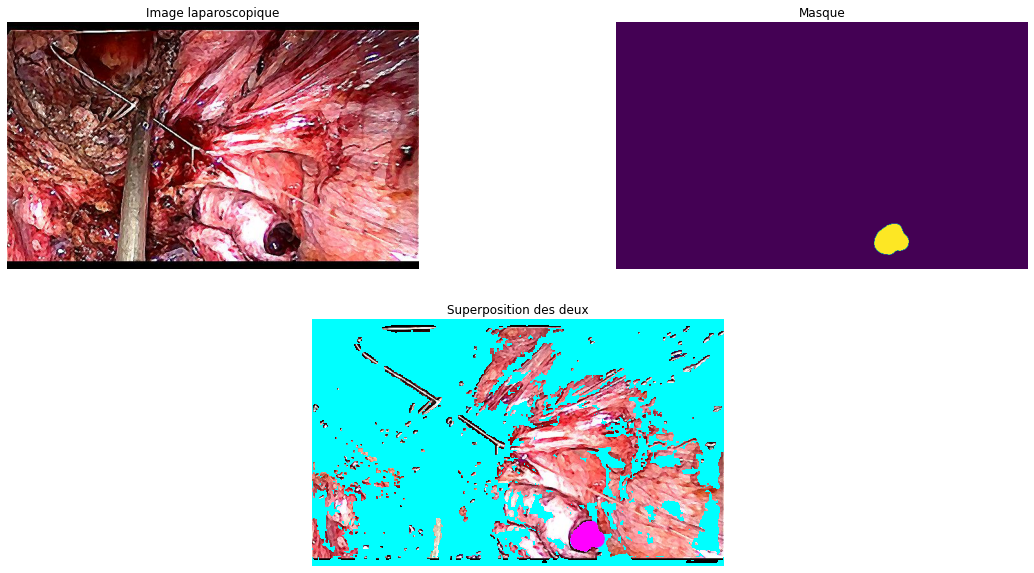

In [3]:
test_image_batch, test_mask_batch = val_img_gen.__next__()
test_img_number = random.randint(0, len(test_image_batch)-1)
test_img = test_image_batch[test_img_number]
print(test_img.shape)
ground_truth=test_mask_batch[test_img_number]
print(ground_truth.shape)

test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input))
print(prediction.shape)
predicted_img=np.reshape(prediction, (384, 640, 1))
print(predicted_img.shape)

disp.plot_pred(test_img, ground_truth, predicted_img)

disp.plot3(test_img, predicted_img)

Comme on peut le voir sur l'image ci-dessus, il est necessaire de procéder à une étape de post-processing pour obtenir le masque finale

In [6]:
print("Nombre de valeurs dans le masque après la prédiction : ", len(np.unique(predicted_img)))
print("Valeurs : ", np.unique(predicted_img))

Nombre de valeurs dans le masque après la prédiction :  198595
Valeurs :  [0.0000000e+00 1.1756970e-38 1.1758853e-38 ... 9.9999988e-01 9.9999994e-01
 1.0000000e+00]


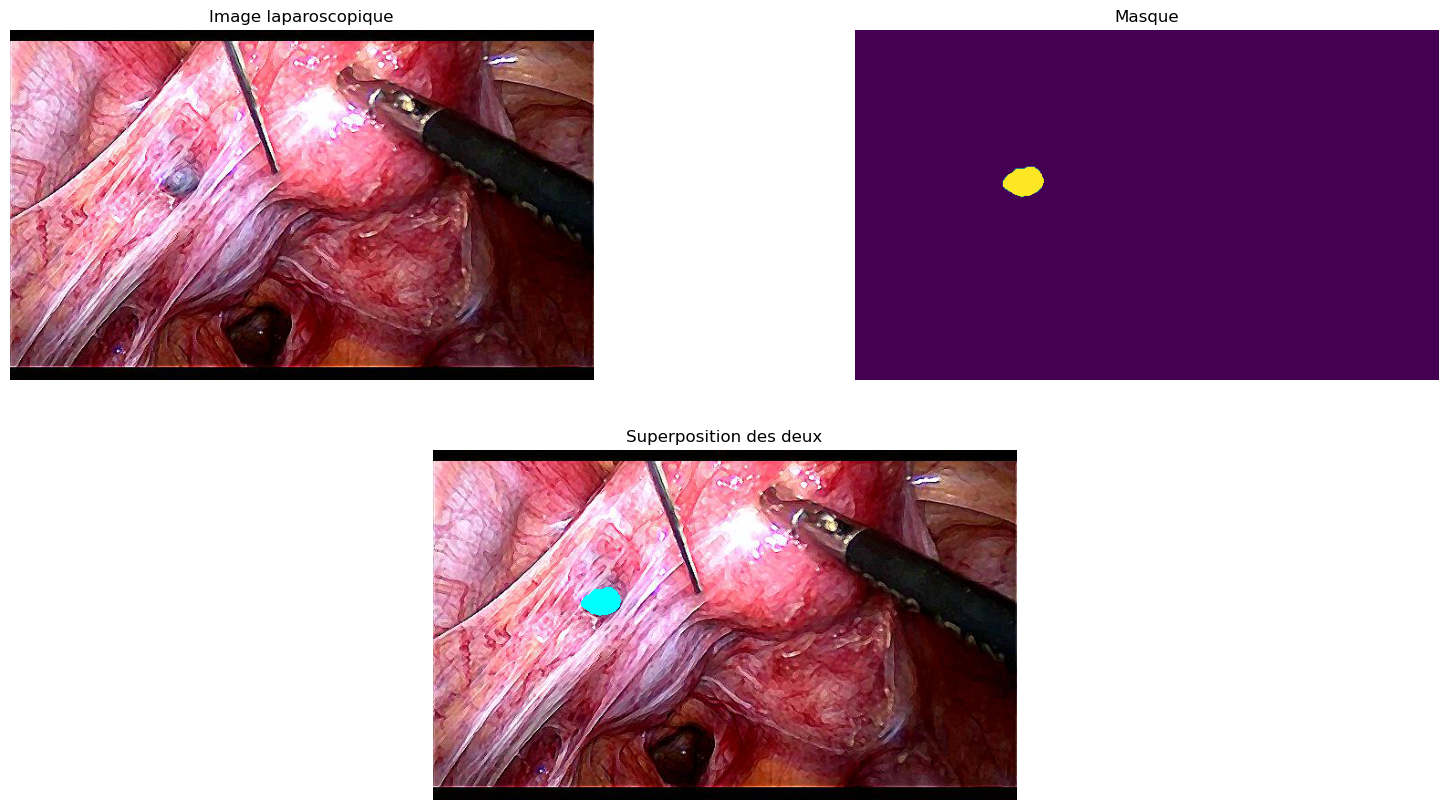

In [7]:
predicted_arr = np.where(predicted_img<0.9, 0, 1)
disp.plot3(test_img, predicted_arr)

In [8]:
IOU_keras = MeanIoU(num_classes=2)  
IOU_keras.update_state(ground_truth, predicted_arr)
print("Mean IoU = ", IOU_keras.result().numpy())

Mean IoU =  0.9263584


Nous allons à présent calculer, pour chaques images du set de validation (set qui n'a jamais été vu par le réseau), la valeur IOU.

In [58]:
histo_iou = []
filelist_img = []
filelist_mask = []

for root, dirs, files in os.walk(val_img_path):
    for file in files:
        filelist_img.append(os.path.join(root, file))

for root, dirs, files in os.walk(val_mask_path):
    for file in files:
        filelist_mask.append(os.path.join(root, file))

filelist_mask.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
filelist_img.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

In [59]:
IOU_keras = MeanIoU(num_classes=2)
batch_size = 20
nb_img = len(filelist_img)
mask_uncounted = 0

for i in range(0, nb_img, batch_size):
    utils.progressBar(i + batch_size, nb_img, "Prédiction")
    end = min(i + batch_size, nb_img)
    nb_batch = end - i
    
    img_batch = np.zeros((nb_batch, 384, 640, 3))
    mask_batch = np.zeros((nb_batch, 384, 640))
    
    for j in range(nb_batch):
        img_batch[j] = utils.getImgPath(filelist_img[i + j])
        mask_batch[j] = utils.getMaskPath(filelist_mask[i + j])
    
    img_batch = img_batch / 255.
    prediction_batch = model.predict(img_batch, verbose = 0)
    predicted_arr_batch = np.where(prediction_batch < 0.5, 0, 1)
    
    for j in range(nb_batch):
        if (len(np.unique(mask_batch[j])) == 2):
            IOU_keras.update_state(mask_batch[j], np.squeeze(predicted_arr_batch[j]))
            histo_iou.append(IOU_keras.result().numpy())
        else:
            mask_uncounted = mask_uncounted + 1
        
        IOU_keras.reset_states()
print("\nNombre de masques non pris en compte : ", mask_uncounted)

Prédiction [████████████████████████████████████████████████████████████] 101 % 
Nombre de masques non pris en compte :  11


In [60]:
np.save('Val_IoU_BC.npy', histo_iou) 

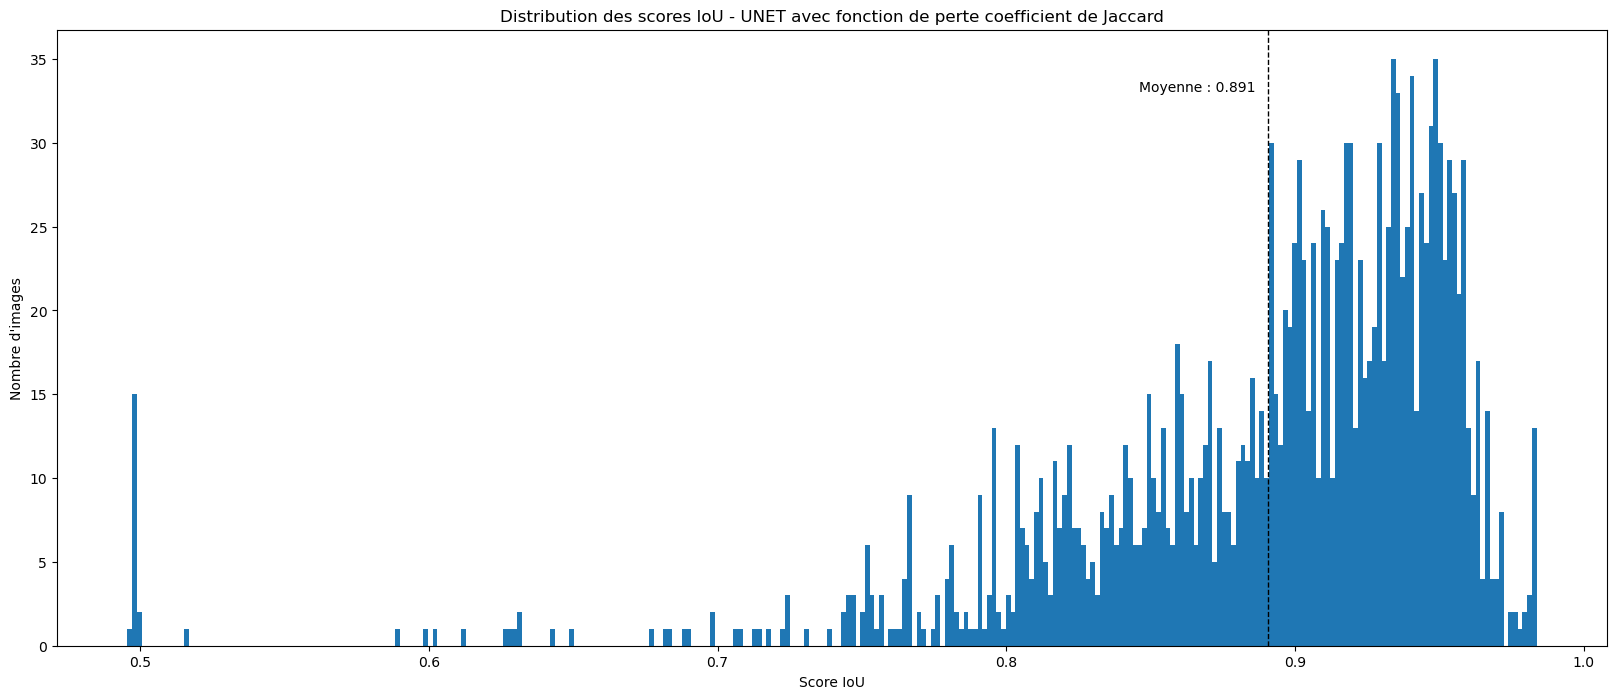

In [62]:
histo_iou = np.load('Val_IoU_Jac.npy')
plt.figure(figsize=(20,8))
plt.hist(histo_iou, 300)
plt.axvline(np.mean(histo_iou), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(np.mean(histo_iou)*0.95, max_ylim*0.9, 'Moyenne : {:.3f}'.format(np.mean(histo_iou)))
plt.title('Distribution des scores IoU - UNET avec fonction de perte coefficient de Jaccard')
plt.xlabel('Score IoU')
plt.ylabel("Nombre d'images")
plt.show()

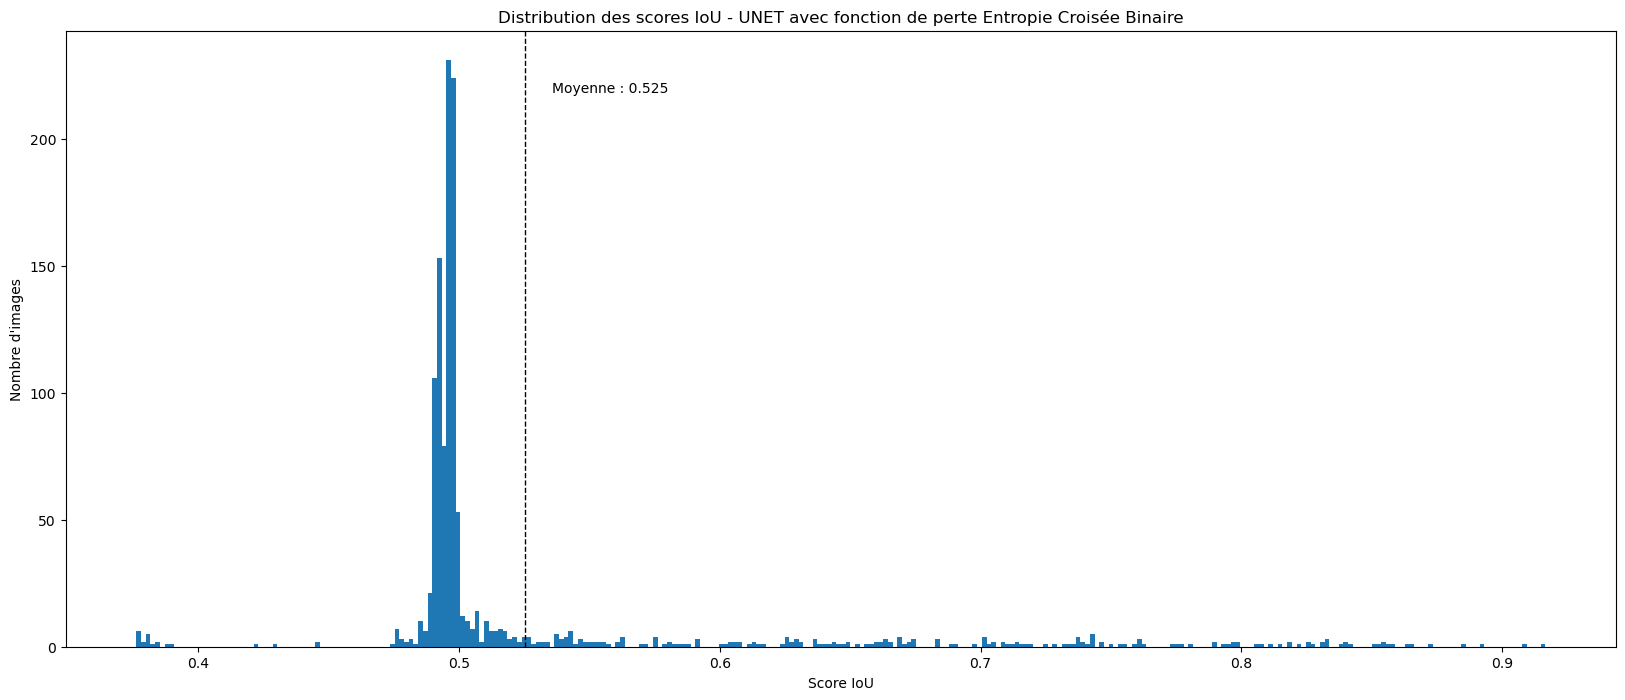

In [67]:
histo_iou = np.load('Val_IoU_BC.npy')
plt.figure(figsize=(20,8))
plt.hist(histo_iou, 300)
plt.axvline(np.mean(histo_iou), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(np.mean(histo_iou)*1.02, max_ylim*0.9, 'Moyenne : {:.3f}'.format(np.mean(histo_iou)))
plt.title('Distribution des scores IoU - UNET avec fonction de perte Entropie Croisée Binaire')
plt.xlabel('Score IoU')
plt.ylabel("Nombre d'images")
plt.show()